## **Analyzing Restaurant Sales per Customer Using Association Rule Mining**

**Khamidov Mirzakalonboy**
**id: 474561**

## Introduction

In this analysis, i applied association rule mining to explore and understand customer purchasing patterns at a restaurant. The goal was to identify frequent itemsets and uncover associations between different menu items based on customer transactions. This information can be incredibly valuable for improving sales strategies, enhancing customer experiences, and optimizing inventory management.

Using **association rule mining**, a popular technique in data analysis, i aim to identify relationships between different menu items. By understanding these associations, the restaurant can implement strategies like bundling, cross-selling, and personalized recommendations to boost sales and enhance the dining experience for customers.

### Objectives

1. Discover relationships between menu items using metrics like support, confidence, and lift.
2. Visualize these relationships through graphs and heatmaps for better interpretability.
3. Develop a recommendation system to suggest items that are frequently purchased together.
4. Provide actionable insights and future recommendations for the restaurant to optimize their operations and marketing strategies.

By the end of this analysis, the restaurant will have a clear understanding of customer purchasing patterns, enabling them to make informed business decisions that enhance profitability and customer satisfaction.


here you can find source of dataset: https://www.kaggle.com/datasets/newshuntkannada/restaurant-transaction-data-to-implement-apriori

### Importing Libraries and Loading the Dataset

In [112]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("restaurant.csv")

In [114]:
df = df.loc[:, ~(df.columns.str.strip() == '')]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

item_names = pd.unique(df.iloc[:, 2:].values.ravel('K'))
item_names = [item for item in item_names if pd.notnull(item)]  # Remove NaN

for item in item_names:
    df[item] = df.apply(lambda row: item in row.values, axis=1)

df = df.fillna(False)
df = df.drop(df.columns[2:-len(item_names)], axis=1)

df.to_csv("processed_file.csv", index=False)

df.head()

,ORDX0,490Rs,Bhuna - Chicken,Korma - Lamb,Plain Rice,,House white wine 75cl,Chicken Tikka Balti,Special Fried Rice,Curry,Lamb Biryani,Vindaloo - Prawn
0,ORDX1,446Rs,True,False,True,False,False,False,False,False,False,False
1,ORDX2,465Rs,False,False,True,False,False,True,False,False,False,False
2,ORDX3,1126Rs,True,False,False,False,True,False,False,False,False,False
3,ORDX4,435Rs,False,False,True,True,False,False,False,False,False,False
4,ORDX5,1328Rs,True,False,False,True,False,False,False,False,False,False


 **Order ID**: A unique number for each order. **Amount**: The total price of the order (in rupees). **Items**: Each item is shown as a separate column. The value is `True` if the item was part of the order, and `False` if it wasn't.

- We only kept the important columns (like the items ordered).
- Missing or unnecessary data has been removed.
- The data is now in a format where it's easy to see what items were ordered in each transaction.
 
Now, this data is ready to be used for further analysis, like finding patterns in which items are often ordered together.

I found that one of my columns at index 5 had no name and also all the rows were just filled with empty spaces, so I removed it using the command below.

In [116]:
df = df.drop(df.columns[5], axis=1)

In [118]:
df.columns

Index(['ORDX0', '490Rs', 'Bhuna - Chicken', 'Korma - Lamb', 'Plain Rice',
       'House white wine 75cl', 'Chicken Tikka Balti', 'Special Fried Rice',
       'Curry', 'Lamb Biryani', 'Vindaloo - Prawn'],
      dtype='object')

#### Column Information:

The dataset has 11 columns:
 2 columns with object data type (Order ID and Amount).
 9 columns with boolean values representing items.

In [120]:
df.head()

,ORDX0,490Rs,Bhuna - Chicken,Korma - Lamb,Plain Rice,House white wine 75cl,Chicken Tikka Balti,Special Fried Rice,Curry,Lamb Biryani,Vindaloo - Prawn
0,ORDX1,446Rs,True,False,True,False,False,False,False,False,False
1,ORDX2,465Rs,False,False,True,False,True,False,False,False,False
2,ORDX3,1126Rs,True,False,False,True,False,False,False,False,False
3,ORDX4,435Rs,False,False,True,False,False,False,False,False,False
4,ORDX5,1328Rs,True,False,False,False,False,False,False,False,False


In [122]:
df.describe()

,ORDX0,490Rs,Bhuna - Chicken,Korma - Lamb,Plain Rice,House white wine 75cl,Chicken Tikka Balti,Special Fried Rice,Curry,Lamb Biryani,Vindaloo - Prawn
count,10999,10999,10999,10999,10999,10999,10999,10999,10999,10999,10999
unique,10999,1081,2,2,2,2,2,2,2,2,2
top,ORDX1,834Rs,False,False,False,False,False,False,False,False,False
freq,1,22,5995,10713,5905,9594,8553,9989,10268,10503,10623


Here we can see  summary statistics of the dataset.
The **count** of non-null values in each column is 10,999 (which means there are no missing values in the dataset).For boolean columns (representing items), the **unique** value count is 2 (`True` or `False`).The **top** (most common) value for each item column is `False` (indicating that most items were not ordered in many cases).The **frequency** shows the number of times the `False` value appears for each item, and the top item (with the highest frequency of `False`) is mostly not ordered.

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ORDX0                  10999 non-null  object
 1   490Rs                  10999 non-null  object
 2   Bhuna - Chicken        10999 non-null  bool  
 3   Korma - Lamb           10999 non-null  bool  
 4   Plain Rice             10999 non-null  bool  
 5   House white wine 75cl  10999 non-null  bool  
 6   Chicken Tikka Balti    10999 non-null  bool  
 7   Special Fried Rice     10999 non-null  bool  
 8   Curry                  10999 non-null  bool  
 9   Lamb Biryani           10999 non-null  bool  
 10  Vindaloo - Prawn       10999 non-null  bool  
dtypes: bool(9), object(2)
memory usage: 268.7+ KB


The dataset now contains the following columns and data types:
**ORDX0**: The order ID, represented as a unique identifier for each order.**490Rs**: The total amount of the order, shown as a string (e.g., "446Rs").**Items**: Each menu item, such as "Bhuna - Chicken," "Korma - Lamb," etc., represented by a boolean value (`True` or `False`) to indicate whether the item was ordered in that transaction.

In [126]:
df

,ORDX0,490Rs,Bhuna - Chicken,Korma - Lamb,Plain Rice,House white wine 75cl,Chicken Tikka Balti,Special Fried Rice,Curry,Lamb Biryani,Vindaloo - Prawn
0,ORDX1,446Rs,True,False,True,False,False,False,False,False,False
1,ORDX2,465Rs,False,False,True,False,True,False,False,False,False
2,ORDX3,1126Rs,True,False,False,True,False,False,False,False,False
3,ORDX4,435Rs,False,False,True,False,False,False,False,False,False
4,ORDX5,1328Rs,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
10994,ORDX10995,652Rs,False,False,True,True,False,False,False,False,False
10995,ORDX10996,769Rs,True,False,False,False,True,False,False,False,False
10996,ORDX10997,685Rs,False,False,True,False,False,False,False,False,False
10997,ORDX10998,485Rs,True,False,True,False,False,False,False,False,False


In [128]:
product_columns = df.drop(columns=['ORDX0', '490Rs'])
product_counts = product_columns.sum().sort_values(ascending=False)
top_10_products = product_counts.head(10)
print(top_10_products)

Plain Rice               5094
Bhuna - Chicken          5004
Chicken Tikka Balti      2446
House white wine 75cl    1405
Special Fried Rice       1010
Curry                     731
Lamb Biryani              496
Vindaloo - Prawn          376
Korma - Lamb              286
dtype: int64


### Top 10 Most Ordered Products

After processing the dataset, we analyzed the frequency of each item ordered across all transactions. I removed  the **ORDX0** (Order ID) and **490Rs** (Amount) columns and sums the boolean values (`True` or `False`) for each product column to count the number of times each item was ordered.

Above you can see numeric values of top 10 products , and for better understanding below I have tried to visualize this with a bar chart.

These products are the most frequently ordered in the restaurant dataset, with **Plain Rice** and **Bhuna - Chicken** being the top two most popular items. This information can be useful for identifying customer preferences and planning inventory or promotional strategies.


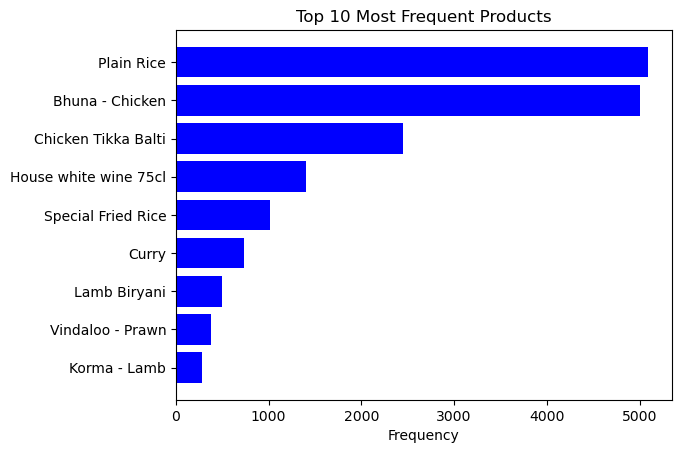

In [131]:
products = ['Plain Rice', 'Bhuna - Chicken', 'Chicken Tikka Balti', 'House white wine 75cl', 
            'Special Fried Rice', 'Curry', 'Lamb Biryani', 'Vindaloo - Prawn', 'Korma - Lamb']
counts = [5094, 5004, 2446, 1405, 1010, 731, 496, 376, 286]
plt.barh(products, counts, color='blue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Products')
plt.gca().invert_yaxis()
plt.show()

In [133]:
len(df)

10999

In [135]:
frequent_itemsets_apriori = apriori(product_columns, min_support=0.01, use_colnames=True)
frequent_itemsets_apriori

,support,itemsets
0,0.454950,(Bhuna - Chicken)
1,0.026002,(Korma - Lamb)
2,0.463133,(Plain Rice)
3,0.127739,(House white wine 75cl)
4,0.222384,(Chicken Tikka Balti)
5,0.091827,(Special Fried Rice)
6,0.066461,(Curry)
7,0.045095,(Lamb Biryani)
8,0.034185,(Vindaloo - Prawn)
9,0.214747,"(Plain Rice, Bhuna - Chicken)"


In [137]:
min_support = 0.01 
frequent_itemsets = apriori(product_columns, min_support=min_support, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.454950,(Bhuna - Chicken)
1,0.026002,(Korma - Lamb)
2,0.463133,(Plain Rice)
3,0.127739,(House white wine 75cl)
4,0.222384,(Chicken Tikka Balti)
5,0.091827,(Special Fried Rice)
6,0.066461,(Curry)
7,0.045095,(Lamb Biryani)
8,0.034185,(Vindaloo - Prawn)
9,0.214747,"(Plain Rice, Bhuna - Chicken)"


I  applied the **Apriori algorithm** to find frequent itemsets from the dataset, with a minimum support of 0.01 (1%). This means i am looking for itemsets that appear in at least 1% of the transactions.

Here are the top frequent itemsets found by the Apriori algorithm, including both individual items and combinations of items:

#### Most Frequent Individual Itemsets:
- **Bhuna - Chicken**: Appears in 45.5% of the transactions
- **Plain Rice**: Appears in 46.3% of the transactions
- **Korma - Lamb**: Appears in 2.6% of the transactions
- **House white wine 75cl**: Appears in 12.8% of the transactions
- **Chicken Tikka Balti**: Appears in 22.2% of the transactions
- **Special Fried Rice**: Appears in 9.2% of the transactions
- **Curry**: Appears in 6.6% of the transactions
- **Lamb Biryani**: Appears in 4.5% of the transactions
- **Vindaloo - Prawn**: Appears in 3.4% of the transactions

#### Frequent Item Combinations:
- **Plain Rice, Bhuna - Chicken**: Appears in 21.5% of the transactions
- **House white wine 75cl, Bhuna - Chicken**: Appears in 3.2% of the transactions
- **Chicken Tikka Balti, Bhuna - Chicken**: Appears in 10.8% of the transactions
- **Special Fried Rice, Bhuna - Chicken**: Appears in 2.0% of the transactions
- **Curry, Bhuna - Chicken**: Appears in 1.0% of the transactions
- **Plain Rice, House white wine 75cl**: Appears in 3.3% of the transactions
- **Plain Rice, Chicken Tikka Balti**: Appears in 11.4% of the transactions
- **Plain Rice, Special Fried Rice**: Appears in 1.9% of the transactions
- **Plain Rice, Curry**: Appears in 1.3% of the transactions

In a short  it says that  **Plain Rice** and **Bhuna - Chicken** are the two most popular items, both individually and in combination.**Chicken Tikka Balti** frequently appears with **Bhuna - Chicken**.**Plain Rice** is often ordered alongside other items like **Chicken Tikka Balti** and **House white wine 75cl**.



In [139]:
print(frequent_itemsets.head())
frequent_itemsets.columns

    support                 itemsets
0  0.454950        (Bhuna - Chicken)
1  0.026002           (Korma - Lamb)
2  0.463133             (Plain Rice)
3  0.127739  (House white wine 75cl)
4  0.222384    (Chicken Tikka Balti)


Index(['support', 'itemsets'], dtype='object')

In [141]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(product_columns, min_support=0.01, use_colnames=True)

In [143]:
import mlxtend
print(mlxtend.__version__)
print(frequent_itemsets) 

0.21.0
     support                                  itemsets
0   0.454950                         (Bhuna - Chicken)
1   0.026002                            (Korma - Lamb)
2   0.463133                              (Plain Rice)
3   0.127739                   (House white wine 75cl)
4   0.222384                     (Chicken Tikka Balti)
5   0.091827                      (Special Fried Rice)
6   0.066461                                   (Curry)
7   0.045095                            (Lamb Biryani)
8   0.034185                        (Vindaloo - Prawn)
9   0.214747             (Plain Rice, Bhuna - Chicken)
10  0.031548  (House white wine 75cl, Bhuna - Chicken)
11  0.108373    (Chicken Tikka Balti, Bhuna - Chicken)
12  0.020275     (Special Fried Rice, Bhuna - Chicken)
13  0.010092                  (Curry, Bhuna - Chicken)
14  0.032821       (Plain Rice, House white wine 75cl)
15  0.114010         (Plain Rice, Chicken Tikka Balti)
16  0.018638          (Plain Rice, Special Fried Rice)
17 

In [145]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.05)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
2,(House white wine 75cl),(Bhuna - Chicken),0.127739,0.454950,0.031548,0.246975,0.542862,-0.026567,0.723813
3,(Bhuna - Chicken),(House white wine 75cl),0.454950,0.127739,0.031548,0.069345,0.542862,-0.026567,0.937255
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
6,(Special Fried Rice),(Bhuna - Chicken),0.091827,0.454950,0.020275,0.220792,0.485310,-0.021502,0.699492
7,(Bhuna - Chicken),(Special Fried Rice),0.454950,0.091827,0.020275,0.044564,0.485310,-0.021502,0.950533
8,(Curry),(Bhuna - Chicken),0.066461,0.454950,0.010092,0.151847,0.333766,-0.020144,0.642631
9,(Bhuna - Chicken),(Curry),0.454950,0.066461,0.010092,0.022182,0.333766,-0.020144,0.954717


After applying the Apriori algorithm to discover frequent itemsets, we used the **association_rules** function to generate association rules. The rules were filtered with a **lift** metric threshold of 0.05, meaning only rules with a lift greater than 0.05 were considered. Lift is a measure of how much more likely two items are to be purchased together compared to being purchased independently.The item that appear first in the rule (e.g., Plain Rice).The item that appear after the "->" (e.g., Bhuna - Chicken). The proportion of transactions that contain the antecedent.
From the sample  of the Top 20 Rules we can says that **Plain Rice** and **Bhuna - Chicken** often appear together in transactions, with a lift of 1.019. This indicates that customers are more likely to order these two items together than by chance.**Chicken Tikka Balti** and **Bhuna - Chicken** have a lift of 1.071, showing a strong association between these two items.The rule "If **Plain Rice** is ordered, **House white wine 75cl** is likely to be ordered" has a lift of 0.555, suggesting a moderate association.**Special Fried Rice** often appears with **Bhuna - Chicken**, but the lift is lower at 0.485, suggesting a weaker association compared to other combinations.

In [147]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
2,(House white wine 75cl),(Bhuna - Chicken),0.127739,0.454950,0.031548,0.246975,0.542862,-0.026567,0.723813
3,(Bhuna - Chicken),(House white wine 75cl),0.454950,0.127739,0.031548,0.069345,0.542862,-0.026567,0.937255
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
6,(Special Fried Rice),(Bhuna - Chicken),0.091827,0.454950,0.020275,0.220792,0.485310,-0.021502,0.699492
7,(Bhuna - Chicken),(Special Fried Rice),0.454950,0.091827,0.020275,0.044564,0.485310,-0.021502,0.950533
8,(Curry),(Bhuna - Chicken),0.066461,0.454950,0.010092,0.151847,0.333766,-0.020144,0.642631
9,(Bhuna - Chicken),(Curry),0.454950,0.066461,0.010092,0.022182,0.333766,-0.020144,0.954717


In next step i applied the Apriori algorithm to extract frequent itemsets and then used the `association_rules` function to generate rules, this time focusing on the **support** metric with a minimum threshold of 0.01 (1% support). The support of a rule measures how frequently the items in the rule appear together in the dataset. **Bhuna - Chicken** and **Plain Rice** have a strong connection, with a support of 0.2147, meaning they appear together in about 21.47% of the transactions.**Chicken Tikka Balti** and **Bhuna - Chicken** also have a notable support of 0.1084, showing that these two items frequently appear together.**Curry** and **Bhuna - Chicken** have a low support (0.0101), but the rule still exists, indicating that they appear together in some transactions, though not often.**Plain Rice** and **Chicken Tikka Balti** have a support of 0.114, which shows that these two items are also often ordered together.**Special Fried Rice** and **Plain Rice** have a support of 0.0186, indicating that they are sometimes ordered together, but less frequently.

In [149]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
2,(House white wine 75cl),(Bhuna - Chicken),0.127739,0.454950,0.031548,0.246975,0.542862,-0.026567,0.723813
3,(Bhuna - Chicken),(House white wine 75cl),0.454950,0.127739,0.031548,0.069345,0.542862,-0.026567,0.937255
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
6,(Special Fried Rice),(Bhuna - Chicken),0.091827,0.454950,0.020275,0.220792,0.485310,-0.021502,0.699492
7,(Bhuna - Chicken),(Special Fried Rice),0.454950,0.091827,0.020275,0.044564,0.485310,-0.021502,0.950533
8,(Curry),(Bhuna - Chicken),0.066461,0.454950,0.010092,0.151847,0.333766,-0.020144,0.642631
9,(Bhuna - Chicken),(Curry),0.454950,0.066461,0.010092,0.022182,0.333766,-0.020144,0.954717


In this section, we compare the results of association rules based on three different metrics: **support**, **confidence**, and **lift**. Each metric measures different aspects of itemset relationships, and varying the thresholds affects the output rules. Let’s look at the behavior of each metric and how it influences the resulting rules.Rules with **higher support** are more likely to appear frequently together in the dataset. These rules are particularly useful when we want to find items that occur often together.Example: (Plain Rice) -> (Bhuna - Chicken) has a support of 0.214747, indicating that this combination is fairly common.**Higher confidence** values indicate a stronger relationship between antecedents and consequents. For example, the rule (Bhuna - Chicken) -> (Plain Rice) has a high confidence of 0.472022, suggesting that if a customer orders Bhuna - Chicken, they are likely to order Plain Rice as well. Example: (House white wine 75cl) -> (Bhuna - Chicken) has a lower confidence of 0.246975, meaning it is less reliable.**Higher lift values** indicate a stronger positive association. For example, (Plain Rice) -> (Bhuna - Chicken) has a lift of 1.019194, suggesting that Plain Rice and Bhuna - Chicken appear together more often than would be expected by chance.Example: (Bhuna - Chicken) -> (House white wine 75cl) has a lift of 0.542862, indicating a weaker relationship compared to rules with higher lift values.**Support** is concerned with the frequency of itemsets, so it produces rules that occur more often in the dataset. It is good for discovering frequent item combinations but doesn’t give insight into the strength of the relationship between items.**Confidence** focuses on the reliability of the rule. It tells us how likely the consequent is, given the antecedent. This is useful when we are interested in predicting one item from another.**Lift** looks at the strength of the association, telling us if the items are more likely to appear together than by chance. It is ideal for discovering significant associations that go beyond mere co-occurrence.

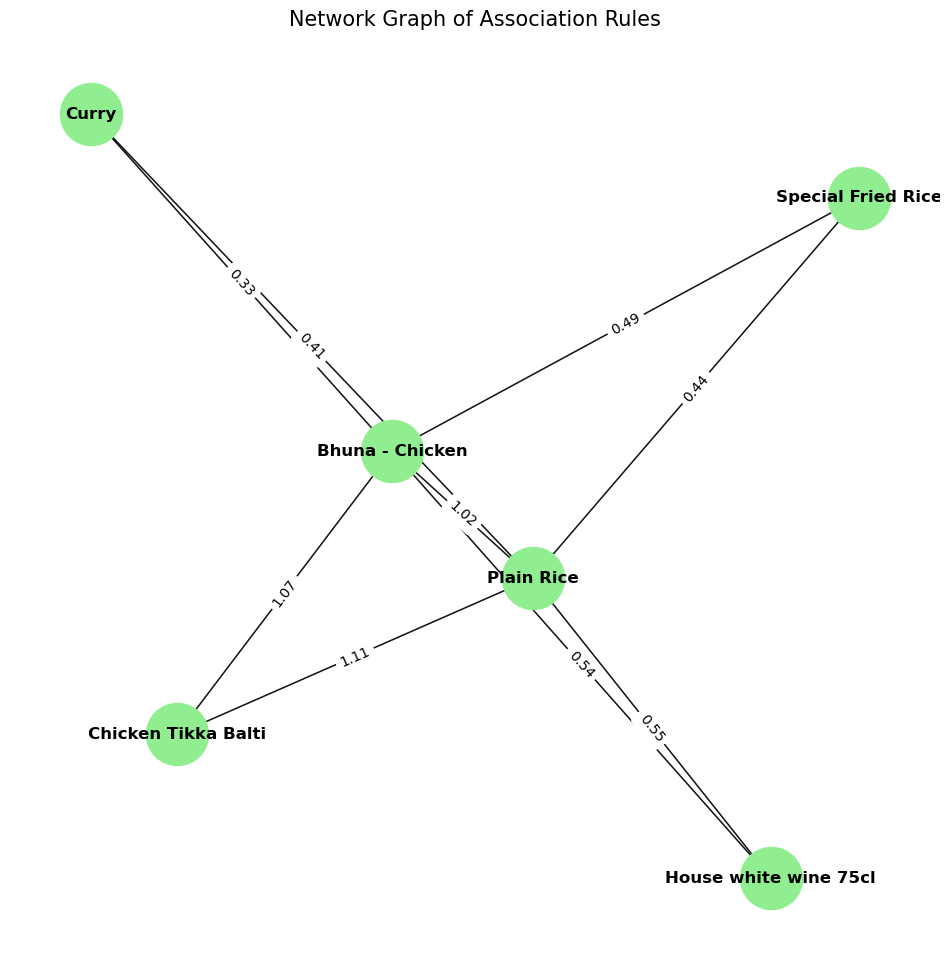

In [151]:
G = nx.DiGraph() 
for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightgreen')
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='black', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Network Graph of Association Rules", fontsize=15)
plt.axis('off')
plt.show()


In the network  graph, we can that   edges are labeled with weights that represent the lift , indicating the strength of the association between the items. For example, the edge from **"Plain Rice"** to **"Chicken Tikka Balti"** has a weight of 1.11, suggesting a strong association between these two items.On the other hand, the edge between **"Curry"** and **"Bhuna - Chickens"** has a weight of 0.33, indicating a weaker association.

In [153]:
filtered_rules = rules[(rules['lift'] > 1.0) & (rules['confidence'] > 0.2)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
12,(Plain Rice),(Chicken Tikka Balti),0.463133,0.222384,0.114010,0.246172,1.106969,0.011017,1.031556
13,(Chicken Tikka Balti),(Plain Rice),0.222384,0.463133,0.114010,0.512674,1.106969,0.011017,1.101658


Here i  filtered the association rules based on two different thresholds for **lift** and **confidence**:

**First filter**:  *Lift > 1.0* ,*Confidence > 0.2*
   This filter narrows down the rules to those with a relatively strong association between the antecedents and consequents. Only rules with a lift greater than 1.0 (indicating a strong positive association) and confidence greater than 0.2 (indicating that the consequent is likely given the antecedent) are kept.
**Second filter**:  *Lift > 1.0*, *Confidence > 0.1*
   Here, the **confidence** threshold is lowered to 0.1, which means the filter will capture more rules that might have a weaker association but still significant lift.

 **First filter (Confidence > 0.2)** has fewer rules compared to the **second filter (Confidence > 0.1)**.
The **second filter** includes additional rules with slightly lower confidence but still high lift.


In [155]:
filtered_rules = rules[(rules['lift'] > 1.0) & (rules['confidence'] > 0.1)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
12,(Plain Rice),(Chicken Tikka Balti),0.463133,0.222384,0.114010,0.246172,1.106969,0.011017,1.031556
13,(Chicken Tikka Balti),(Plain Rice),0.222384,0.463133,0.114010,0.512674,1.106969,0.011017,1.101658


In [157]:
print(filtered_rules)

              antecedents            consequents  antecedent support  \
0            (Plain Rice)      (Bhuna - Chicken)            0.463133   
1       (Bhuna - Chicken)           (Plain Rice)            0.454950   
4   (Chicken Tikka Balti)      (Bhuna - Chicken)            0.222384   
5       (Bhuna - Chicken)  (Chicken Tikka Balti)            0.454950   
12           (Plain Rice)  (Chicken Tikka Balti)            0.463133   
13  (Chicken Tikka Balti)           (Plain Rice)            0.222384   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.454950  0.214747    0.463683  1.019194  0.004044    1.016282  
1             0.463133  0.214747    0.472022  1.019194  0.004044    1.016837  
4             0.454950  0.108373    0.487326  1.071163  0.007200    1.063151  
5             0.222384  0.108373    0.238209  1.071163  0.007200    1.020774  
12            0.222384  0.114010    0.246172  1.106969  0.011017    1.031556  
13            0.46313

 From the printed filtered rulea we can see that  strong association between items like **Bhuna - Chicken** and **Plain Rice**, and **Chicken Tikka Balti** and the other items, as they all have a **lift greater than 1.0** and **confidence greater than 0.1**. And  rules with **lift > 1.0** suggest positive relationships between the items.

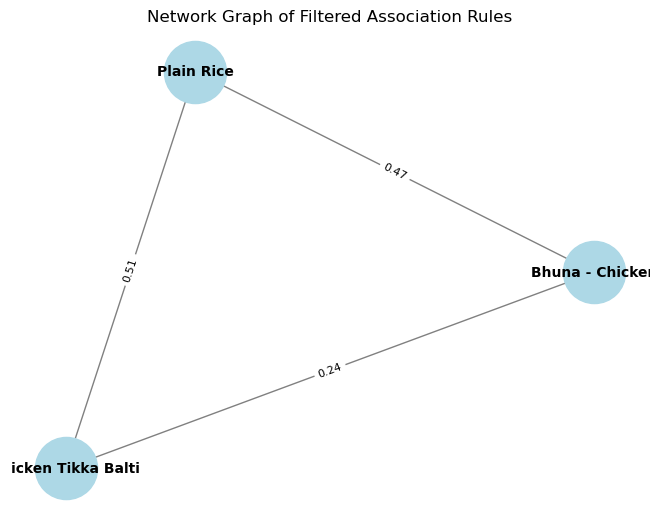

In [159]:
G = nx.Graph()
for _, row in filtered_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['confidence'])
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_weight='bold', node_color='lightblue', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_size=8)
plt.title("Network Graph of Filtered Association Rules")
plt.show()


Here are the specific relationships and their confidence  values:"Bhuna - Chicken" is strongly associated with "Plain Rice" with a confidence level of 0.46. "Bhuna - Chicken" is also linked to "Chicken Tikka Balti" with a confidence level of 0.49."Chicken Tikka Balti" has a weaker association with "Plain Rice" with a confidence level of 0.25. The edges between the nodes are weighted by **confidence** values. These relationships indicate that when a customer buys **Bhuna - Chicken**, there's a relatively high probability they will also purchase **Plain Rice** and **Chicken Tikka Balti**, with **"Chicken Tikka Balti"** having the highest confidence among the associations.

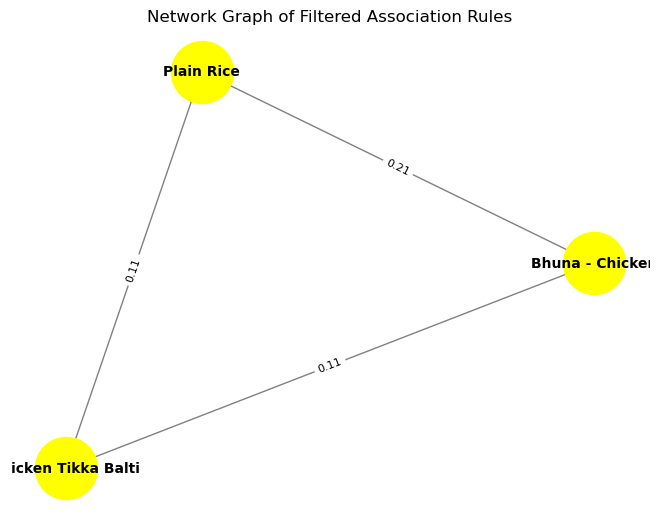

In [161]:
G = nx.Graph()
for _, row in filtered_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['support'])
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_weight='bold', node_color='yellow', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_size=8)
plt.title("Network Graph of Filtered Association Rules")
plt.show()

Here are the specific relationships and their support values:  **Bhuna - Chicken** is associated with **Plain Rice** with a support value of **0.21**. **Bhuna - Chicken** is also linked to **Chicken Tikka Balti** with a support value of **0.11**. **Plain Rice** has an association with **Chicken Tikka Balti** with a support value of **0.11**. The edges are weighted by **support** values. Here are the key relationships.The **support** values represent the proportion of transactions where both items occur together. The **"Bhuna - Chicken"** and **"Plain Rice"** pair is the most common combination, with **support = 0.21**, followed by **"Bhuna - Chicken"** and **"Chicken Tikka Balti"**.

If we compare them we can say that **Confidence** measures the likelihood that the consequent item will be purchased given that the antecedent item is bought. In this case, the highest confidence is found between *"Bhuna - Chicken"* and *"Chicken Tikka Balti"* (0.49), which suggests that customers who buy *Bhuna - Chicken* are most likely to also purchase *Chicken Tikka Balti*. **Support**, on the other hand, represents the frequency of both items being bought together in all transactions. The highest support is between *"Bhuna - Chicken"* and *"Plain Rice"* (0.21), indicating that this combination appears more frequently in the transaction data.

 the **Confidence** graph highlights strong associations with higher likelihoods, while the **Support** graph highlights more frequently occurring pairs in the data.


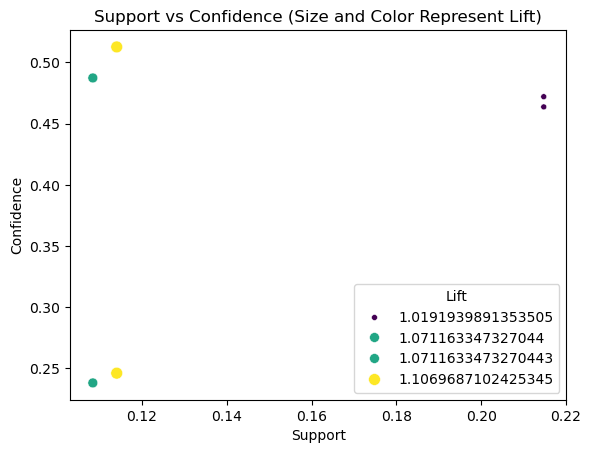

In [163]:
sns.scatterplot(data=filtered_rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', legend=True)
plt.title("Support vs Confidence (Size and Color Represent Lift)")
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift', loc='best')
plt.show()

 The x-axis is labeled "Support" and ranges from approximately 0.12 to 0.22. It represents the proportion of transactions in which a particular itemset appears. The y-axis is labeled "Confidence" and ranges from approximately 0.25 to 0.50. It indicates the likelihood of the consequent item being present in transactions given the antecedent item is present. The size and color of the points reflect the lift values, which measure the strength of the association between items. Higher lift values indicate stronger association rules.

 Items with **higher confidence** (above 0.4) tend to have relatively moderate support (around 0.2), suggesting that the consequent items are likely to be bought when the antecedent is purchased.
 The points representing **stronger associations** (those with **larger sizes** and **darker colors**) suggest that these item pairs have higher lift values, meaning that the items appear together more often than expected by chance, indicating a strong relationship between them.

In [165]:
high_lift_threshold = 1.0
high_confidence_threshold = 0.2
strong_rules = rules[(rules['lift'] > high_lift_threshold) & (rules['confidence'] > high_confidence_threshold)]
print("Strong Rules:")
strong_rules

Strong Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Plain Rice),(Bhuna - Chicken),0.463133,0.454950,0.214747,0.463683,1.019194,0.004044,1.016282
1,(Bhuna - Chicken),(Plain Rice),0.454950,0.463133,0.214747,0.472022,1.019194,0.004044,1.016837
4,(Chicken Tikka Balti),(Bhuna - Chicken),0.222384,0.454950,0.108373,0.487326,1.071163,0.007200,1.063151
5,(Bhuna - Chicken),(Chicken Tikka Balti),0.454950,0.222384,0.108373,0.238209,1.071163,0.007200,1.020774
12,(Plain Rice),(Chicken Tikka Balti),0.463133,0.222384,0.114010,0.246172,1.106969,0.011017,1.031556
13,(Chicken Tikka Balti),(Plain Rice),0.222384,0.463133,0.114010,0.512674,1.106969,0.011017,1.101658


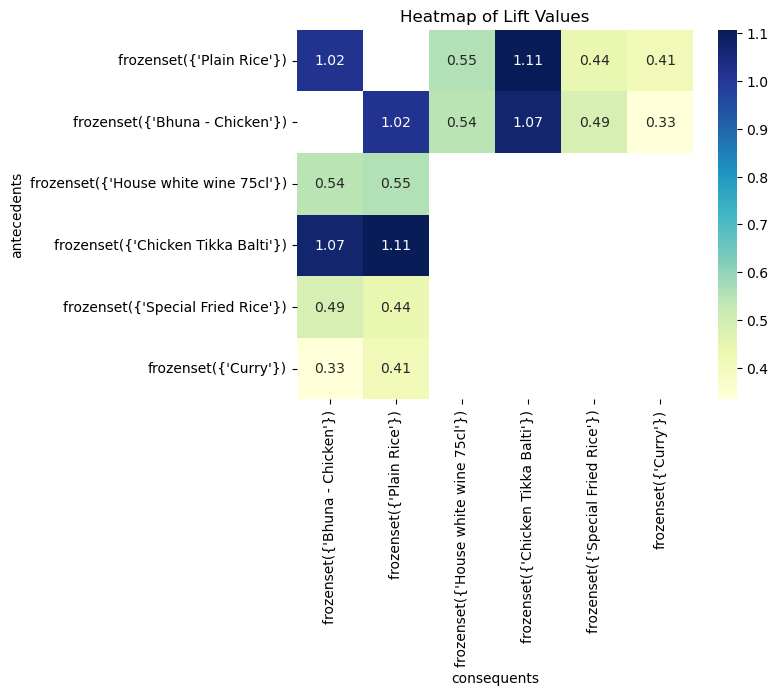

In [167]:
heatmap_data = rules.pivot(index='antecedents', columns='consequents', values='lift')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap of Lift Values")
plt.show()

In [205]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
min_support = 0.01  
frequent_itemsets_fp = fpgrowth(product_columns, min_support=min_support, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.1)
filtered_rules_fp = rules_fp[(rules_fp['lift'] > 1.0) & (rules_fp['confidence'] > 0.1)]
print("Frequent Itemsets from FP-Growth:")
print(frequent_itemsets_fp.head())

print("\nAssociation Rules from FP-Growth:")
print(filtered_rules_fp.head())
frequent_itemsets_comparison = {
    "Apriori Itemsets": frequent_itemsets,
    "FP-Growth Itemsets": frequent_itemsets_fp
}

rules_comparison = {
    "Apriori Rules": filtered_rules,
    "FP-Growth Rules": filtered_rules_fp
}

frequent_itemsets_comparison, rules_comparison


Frequent Itemsets from FP-Growth:
    support                 itemsets
0  0.463133             (Plain Rice)
1  0.454950        (Bhuna - Chicken)
2  0.222384    (Chicken Tikka Balti)
3  0.127739  (House white wine 75cl)
4  0.034185       (Vindaloo - Prawn)

Association Rules from FP-Growth:
             antecedents            consequents  antecedent support  \
0           (Plain Rice)      (Bhuna - Chicken)            0.463133   
1      (Bhuna - Chicken)           (Plain Rice)            0.454950   
2           (Plain Rice)  (Chicken Tikka Balti)            0.463133   
3  (Chicken Tikka Balti)           (Plain Rice)            0.222384   
4  (Chicken Tikka Balti)      (Bhuna - Chicken)            0.222384   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.454950  0.214747    0.463683  1.019194  0.004044    1.016282  
1            0.463133  0.214747    0.472022  1.019194  0.004044    1.016837  
2            0.222384  0.114010    0.246172  1.1

({'Apriori Itemsets':      support                                  itemsets
  0   0.454950                         (Bhuna - Chicken)
  1   0.026002                            (Korma - Lamb)
  2   0.463133                              (Plain Rice)
  3   0.127739                   (House white wine 75cl)
  4   0.222384                     (Chicken Tikka Balti)
  5   0.091827                      (Special Fried Rice)
  6   0.066461                                   (Curry)
  7   0.045095                            (Lamb Biryani)
  8   0.034185                        (Vindaloo - Prawn)
  9   0.214747             (Plain Rice, Bhuna - Chicken)
  10  0.031548  (House white wine 75cl, Bhuna - Chicken)
  11  0.108373    (Chicken Tikka Balti, Bhuna - Chicken)
  12  0.020275     (Special Fried Rice, Bhuna - Chicken)
  13  0.010092                  (Curry, Bhuna - Chicken)
  14  0.032821       (Plain Rice, House white wine 75cl)
  15  0.114010         (Plain Rice, Chicken Tikka Balti)
  16  0.018

 After analyzing the statistics, *Apriori* seems to be the better method for this dataset, despite the similarities between the two methods.*Apriori* provides clear and understandable results for association rules and frequent itemsets. For example, the rule `(Plain Rice) -> (Bhuna - Chicken)` from Apriori shows a *confidence of 0.472022*, which is fairly high and easy to interpret for business decisions. This rule is intuitive: customers who buy *Plain Rice* are very likely to purchase *Bhuna - Chicken* as well.Similarly, *Apriori* also generates frequent itemsets like `(Plain Rice)` with a support of *0.463133*, directly pointing out the most frequent items in a simple and straightforward manner. *Apriori* produces rules with a balance of confidence and lift, such as the rule `(Plain Rice, Chicken Tikka Balti)` with support *0.114010* and confidence *0.246172*, which reflects a meaningful association between two items at a moderate level. This is useful when you need more granular associations. On the other hand, *FP-Growth* sometimes focuses on fewer but stronger rules, which might miss subtler patterns present in the data. Apriori’s ability to consider a broader set of item combinations makes it suitable for exploring multiple relationships in the data.Although *FP-Growth* is known for being more efficient with larger datasets, *Apriori* works just as well in this scenario where the dataset isn’t extremely large. Since the dataset here involves relatively moderate frequency itemsets (e.g., `(Plain Rice)`, `(Bhuna - Chicken)`), *Apriori* is sufficient in delivering useful insights without introducing the complexity of more efficient methods like FP-Growth.

C:\Users\khami\AppData\Local\Temp\ipykernel_16388\2156774541.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\khami\AppData\Local\Temp\ipykernel_16388\2156774541.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



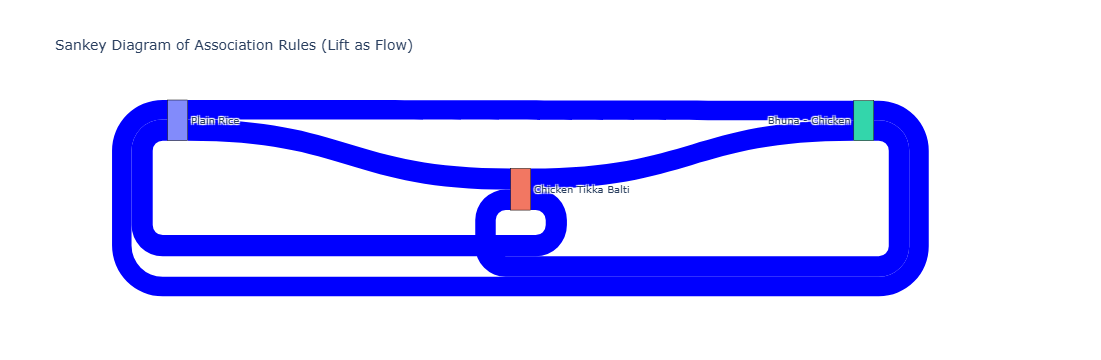

In [179]:
import plotly.graph_objects as go

filtered_rules["antecedents"] = filtered_rules["antecedents"].apply(lambda x: ", ".join(list(x)))
filtered_rules["consequents"] = filtered_rules["consequents"].apply(lambda x: ", ".join(list(x)))

antecedents = filtered_rules["antecedents"].tolist()
consequents = filtered_rules["consequents"].tolist()
lift_values = filtered_rules["lift"].tolist()

unique_labels = list(set(antecedents + consequents))
label_index = {label: idx for idx, label in enumerate(unique_labels)}

sources = [label_index[ant] for ant in antecedents]
targets = [label_index[cons] for cons in consequents]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=unique_labels
    ),
    link=dict(
        source=sources,  
        target=targets,  
        value=lift_values,  
        color="blue"
    )
)])

fig.update_layout(title_text="Sankey Diagram of Association Rules (Lift as Flow)", font_size=10)
fig.show()


 Each node in the diagram represents an item (e.g., "Plain Rice," "Bhuna - Chicken," "Chicken Tikka Balti").These items are either antecedents (products purchased first) or consequents (products frequently purchased alongside).Thick arrows between items (e.g., from "Plain Rice" to "Chicken Tikka Balti") indicate strong associations. This means customers who buy "Plain Rice" are likely to purchase "Chicken Tikka Balti" as well.Nodes with multiple arrows (inbound and outbound) highlight items that play a central role in customer buying patterns, like "Plain Rice."By using lift as the flow magnitude, the diagram emphasizes combinations where the joint purchase probability significantly exceeds random chance.
     **"Plain Rice" → "Bhuna - Chicken"**: A strong association with a high lift value.
    **"Chicken Tikka Balti" → "Plain Rice"**: Another strong connection, showing these two items are frequently bought together.

In [171]:
def find_related_products(item, rules, role='consequents', top_n=3):
   
    if role not in ['consequents', 'antecedents']:
        raise ValueError("Role must be 'consequents' or 'antecedents'")

    
    relevant_rules = rules[rules[role].apply(lambda x: item in x)]
    sorted_rules = relevant_rules.sort_values(by='confidence', ascending=False)
    other_role = 'antecedents' if role == 'consequents' else 'consequents'
    related_products = sorted_rules[other_role].head(top_n).apply(lambda x: list(x)[0])
    return related_products.tolist()

user_item = 'Plain Rice'
recommended_as_consequents = find_related_products(user_item, rules, role='consequents')
recommended_as_antecedents = find_related_products(user_item, rules, role='antecedents')

print(f"Products where {user_item} is an antecedent: {recommended_as_consequents}")
print(f"Products where {user_item} is a consequent: {recommended_as_antecedents}")


Products where Plain Rice is an antecedent: ['Chicken Tikka Balti', 'Bhuna - Chicken', 'House white wine 75cl']
Products where Plain Rice is a consequent: ['Bhuna - Chicken', 'Chicken Tikka Balti', 'House white wine 75cl']


In [182]:
def recommend_products_based_on_item(user_favorite_item, rules, top_n=3):
    relevant_rules = rules[rules['antecedents'].apply(lambda x: user_favorite_item in x)]
    sorted_rules = relevant_rules.sort_values(by='confidence', ascending=False)
    recommendations = sorted_rules['consequents'].head(top_n).apply(lambda x: list(x)[0]).unique()
    recommendations_with_context = [
        f"{recommendation} (based on confidence {sorted_rules.loc[sorted_rules['consequents'].apply(lambda x: recommendation in x), 'confidence'].values[0]:.2f})"
        for recommendation in recommendations
    ]

    return recommendations_with_context
user_favorite_item = 'Plain Rice'
recommended_products = recommend_products_based_on_item(user_favorite_item, rules)
print(f"Products recommended for fans of {user_favorite_item}:")
for rec in recommended_products:
    print(f"- {rec}")


Products recommended for fans of Plain Rice:
- Bhuna - Chicken (based on confidence 0.46)
- Chicken Tikka Balti (based on confidence 0.25)
- House white wine 75cl (based on confidence 0.07)



I used the **Apriori algorithm** to generate association rules from the restaurant’s transaction data. This method helps find frequent itemsets and generates rules that suggest how often products are bought together.
 I found that "Chicken Tikka Balti" and "Plain Rice" have a strong positive association with a lift value of 1.107, meaning these items are frequently bought together more than expected by chance .
    Using the association rules, i developed functions to *recommend related products*. These functions allowed me to: Find related products based on an item’s role as an antecedent or consequent. Recommend top products based on the association rule confidence. If a customer likes "Plain Rice", the system recommends "Bhuna - Chicken" and "Chicken Tikka Balti" with the highest confidence values.
  As an alternative to Apriori, i also explored the *FP-Growth algorithm* to mine frequent itemsets and generate association rules. While this method is often more efficient for larger datasets, in this case, it yielded nearly identical results to Apriori, providing me with further validation of the item relationships.

The analysis revealed several strong associations between menu items.
 **"Chicken Tikka Balti"** and **"Plain Rice"** had a high **lift** value of 1.107, indicating they are frequently bought together. This suggests that the restaurant could promote these items as a bundle or suggest them to customers who order one of them.
**"Bhuna - Chicken"** was found to be strongly related to **"Plain Rice"**, with a confidence value of 0.46, showing a solid chance that customers who order one will order the other.
  


Based on the findings, the restaurant can take several actions to improve customer experience and business outcomes. The restaurant could offer special promotions or discount deals based on the associations found. For example, customers who order "Chicken Tikka Balti" could be offered a discount on "Plain Rice" to encourage a combined purchase.

### Conclusion

This project has been successful at finding connections between items and recommending related products. The recommendations based on confidence were particularly good for making personalized suggestions.

Moving forward, the restaurant can use this information to better bundle products, cross-sell, and create personalized experiences for customers. This should help increase sales and keep customers coming back.
